## **Импорты**

In [151]:
import numpy as np
import matplotlib.pyplot as plt
import random

from scipy.integrate import quad

## **Границы**

In [152]:
rng = 5

a = -rng
b = rng
prec = 0.01

## **Отрисовка**

In [153]:
def ShowFunc(func , name):
  plt.figure(figsize=(14,3))
  plt.title(name)
  arr= [func(i) for i in np.arange(a,b,prec) ]
  axis = np.arange(a,b,prec) 
  plt.plot( axis , arr,'r-')
  plt.grid(True)
  plt.show()

def ShowArr(arr , name):
  plt.figure(figsize=(14,3))
  plt.title(name)
  axis = np.arange(a,b,prec) 
  plt.plot( axis , arr,'r-')
  plt.grid(True)
  plt.show()

def ShowFourier(arr, name):
  plt.figure(figsize=(14,3))
  plt.title(name)
  axis = [i*1/prec/len(arr) for i in range(len(arr))]
  plt.xlim (0, np.max(axis)/2)
  plt.plot( axis , arr,'r-')
  plt.grid(True)
  plt.show()


In [154]:
def MeanSlider(arr , around):
  res = np.zeros(len(arr))
  step = int(around/2)
  orig_plus_zeros = np.zeros(len(arr) + 2*around)
  orig_plus_zeros[around: (len(arr) + around)] = arr 

  for i in range(len(arr)):
    res[i] = np.mean(orig_plus_zeros[i: i + 2*around+1])
  return res

## **Свертка**

In [155]:
def convol(func1 , func2):
  conv = np.convolve(func1 ,func2)
  a1 = abs(round(a/prec))
  b1 = abs(round((b-a)/prec)) + abs(round(a/prec))
  return conv[a1:b1]

## **Оригинал фильтра**

In [156]:
def rect(w1,w2):
  return lambda x: 1 if w1<x and x<w2 else 0
def rect_slider(w1,w2,s):
  return lambda x: 1 if w1<x and x<w2 else max(1 -  (abs(x) + w1)/s,0) if x<w1 else max(1 -  (abs(x)- w2)/s,0) if x>w2 else 0


def phaseMode(rect_arr):
  steps = 0
  for i in rect_arr:
    if i == 1:
      steps+=1
  phase = np.array([np.exp(1j*0) for i in rect_arr])
  result = np.array([rect_arr[idx]*phase[idx] for idx in range(rect_arr.shape[0])])
  step = 0
  for idx in range(rect_arr.shape[0]):
    if rect_arr[idx] == 1:
      result[idx] *= np.exp(1j*(np.pi - 2*np.pi*step/steps))
      step += 1
    else:
      result[idx] = rect_arr[idx]

  #ShowArr(np.abs(result),'Abs')
  #ShowArr(np.angle(result),'Image')

  return result

def rect2(a,b):
  return lambda x: 0 if (x<a)or(x>b) else np.cos(np.pi/(2*(b-a))*x)+1j*np.sin(np.pi/(2*(b-a))*x)

def filter(w1,w2):

  if w1<= 0 and w2 <=0 :
    rect_arr = np.array([rect(-w1,-w2)(i) for i in np.arange(0,b-a,prec)])
    rect_arr = np.where(rect_arr == 1 , 0 , 1)
  else:
    rect_arr = np.array([rect(w1,w2)(i) for i in np.arange(0,b-a,prec)])
  
  #rect_arr = np.array([rect2(w1,w2)(i) for i in np.arange(0,b-a,prec)])
  #ShowArr(np.abs(rect_arr),'1')
  #ShowArr(np.angle(rect_arr),'1')

  result = phaseMode(rect_arr)
  result = rect_arr

  furier_ideal = np.concatenate([result[:len(result)//2], np.flip(result[:len(result)//2])])

  #ShowArr(np.abs(furier_ideal) , "result abs")
  #ShowArr(np.angle(furier_ideal) , "result angle ")

  fil = np.fft.ifft(furier_ideal)
  tmp = np.split(fil, 2)  
  return np.concatenate([tmp[1], tmp[0]])

# **Функции для тестов**

##**Фильтры частот**

In [157]:
def TestFourierFilter(func,a1,b1 , r1,r2): 
  a1 = a1/50*rng
  b1 = b1/50*rng 

  ideal_fil = filter(a1,b1)

  rct = [rect_slider(r1,r2,0.7)(x) for x in np.arange(a,b,prec)]
  fil = rct * ideal_fil

  ShowArr(ideal_fil,"Ideal Filter abs")
  #ShowArr(np.imag(ideal_fil),"Ideal Filter imag")
  ShowArr(fil,"Filter")

  #ShowFourier(np.real(np.fft.fft(ideal_fil)) ,"Ideal filter fourier")
  #ShowFourier(np.real(np.fft.fft(fil)) , 'Filter fourier')

  ShowFourier(np.imag(np.fft.fft(ideal_fil)) ,"Ideal filter fourier imag")
  ShowFourier(np.imag(np.fft.fft(fil)) , 'Filter fourier imag')

  four_sign = np.fft.fft([func(i) for i in np.arange(a,b,prec)])
  
  func_res = [func(i) for i in np.arange(a,b,prec) ]
  
  result = np.real(convol(func_res , fil))

  ShowFourier(abs(four_sign),"Function fourier before")
  ShowFourier(np.abs(np.fft.fft(result)) , "Function fourier after")


  ShowArr(func_res,"Before filter")
  ShowArr(result,"After filter")


##**Фильтр скользящего среднего**

In [158]:
def TestMeanSlider(func,knn):
  arr = [func(i) for i in np.arange(a,b,prec)]
  ShowArr(arr , "Original")
  ShowArr(MeanSlider( arr, knn), "MeanSlider")

  arr2 = np.zeros_like(arr)

  arr2[10] = 1

  freq = np.fft.fft(MeanSlider( arr2, knn))
  ShowFourier(np.abs(freq) , "АЧХ")

# **Тесты**

## **Фильтры частот**

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


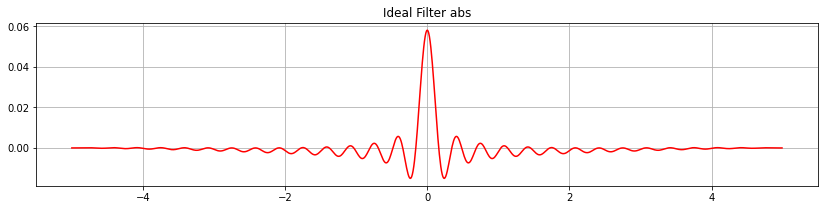

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


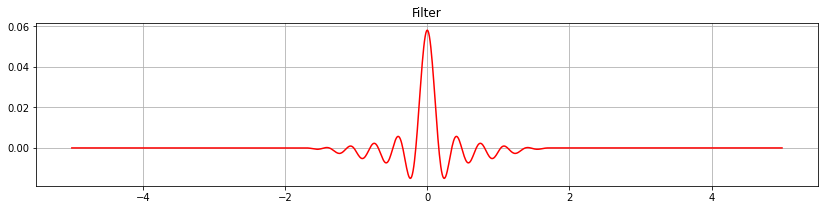

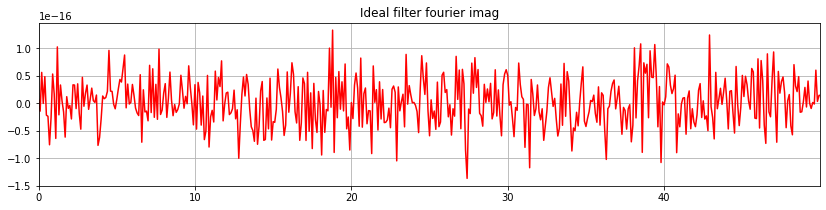

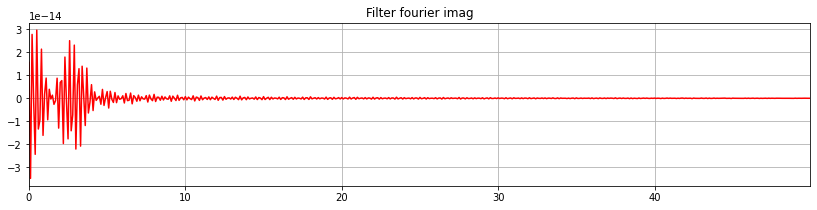

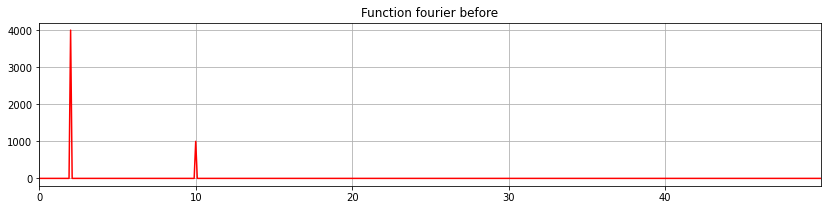

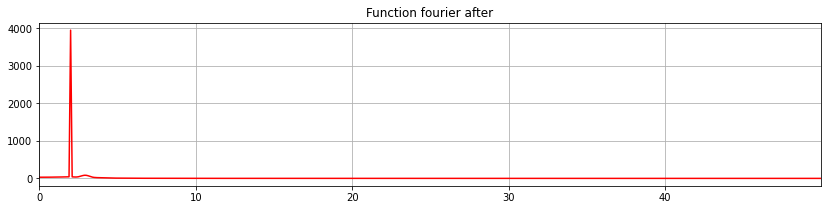

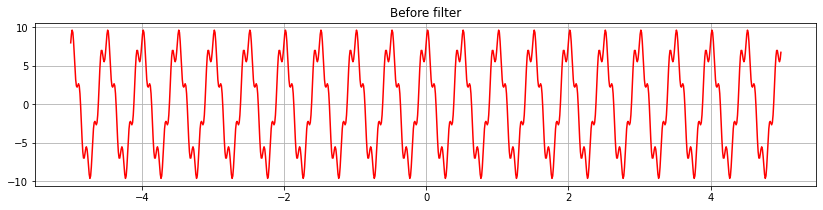

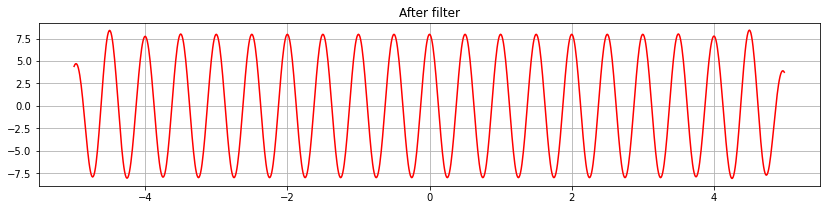

In [159]:
def cos_sin(a1,a2,w1,w2):
  return lambda x: a1*np.cos(w1*x*np.pi*2) + a2*np.sin(w2*x*np.pi*2)
TestFourierFilter(cos_sin(8,2,2,10) ,0, 3 , -1,1)

##**Фильтры скользящего среднего**

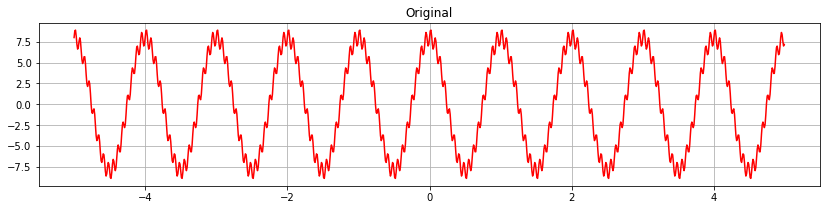

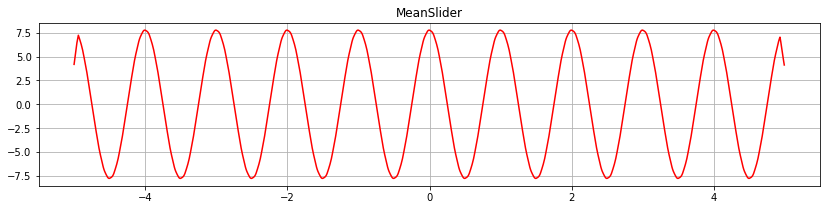

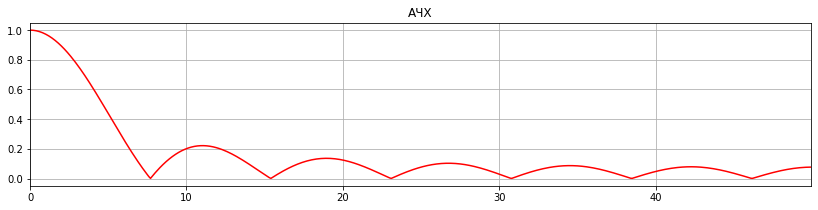

In [160]:
TestMeanSlider(cos_sin(8,1,1,15),6)

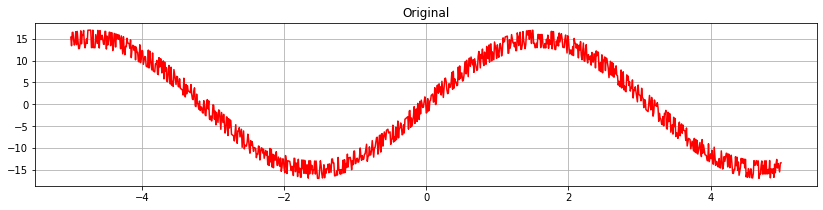

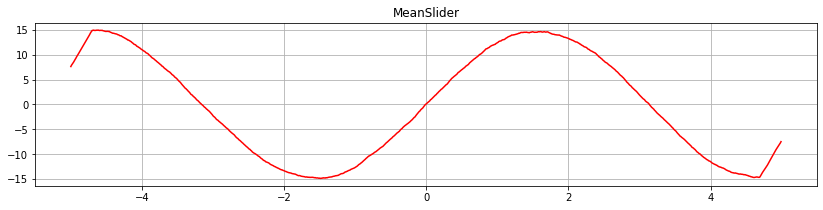

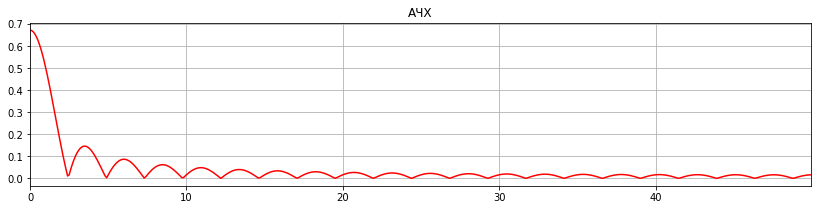

In [161]:
def sin_plus_rand(a,w,b):
  return lambda x: a*np.sin(x*w) + random.randint(-b,b) 
TestMeanSlider(sin_plus_rand(15,1,2),30)